# Assignments - module 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vigji/python-cimec/blob/main/assignments/Assignments_1.ipynb)

This notebook contains the assignments to complete for credits for the first module.

**Submission**: Once you're happy with your solutions, send it to me in any form (email the file, share it through Colab/Google Drive, send me a link to your GitHub repo...).

**Deadline**: 15th of July 2023

**Evaluation**: There is no grade, but I will pass assignments that showcase a reasonable degree of understanding og the covered topics. Do your best, and feel free to ask for help if you are struggling!

(Also, try to keep in mind not only the goal of the exercise, but also all the coding best practices we have been considering in the lectures.)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## 0. Spike detection

In this exercise we will be playing around with some (dummy) electrophysiology recordings. Let's start by having a look at the raw data!

In [ ]:
def generate_spike_trace(trace_length=60, firing_rate=1, noise_sigma = 0.05):
    """Function to generate a fake extracellular recording.

    Parameters
    ----------
        trace_length : float
            Duration of the recording in seconds.

        firing_rate : float
            Average firing rate of the neuron in Hz.

        noise_sigma : float
            Noise level.


    Returns:
    --------
        np.array
            Fake extracellular recording.

    """
    np.random.seed(42)
    FS = 10000  # sampling frequency
    n = int(trace_length * FS)  # number of samples

    # Generate spike shape template as a difference of Gaussians.
    # A horrible bunch of magic numbers - do not imitate!
    x = np.arange(30)
    spike_template = np.exp(-(x - 10)**2/6) - np.exp(-(x - 12)**2/16)*0.8

    # Generate spike times from a gaussian distribution:
    spikes_times = np.random.poisson(firing_rate / FS, n)

    # Convolve dirac delta functions of spike times with spike template:
    trace = np.convolve(spikes_times, spike_template)[:n]

    # Add some gaussian noise:
    trace += np.random.normal(0, noise_sigma, n)

    return trace

### Exercise 0.0

Run the function below to generate an synthetic extracellular recording for a neuron. Make a nice plot with the trace; the spikes are the peaks appearing above the noise!

---

(_Optional_) If you want to make a plot with exact x coordinates in seconds, you should know that the trace is sampled at 10000 Hz (10000 points per second).

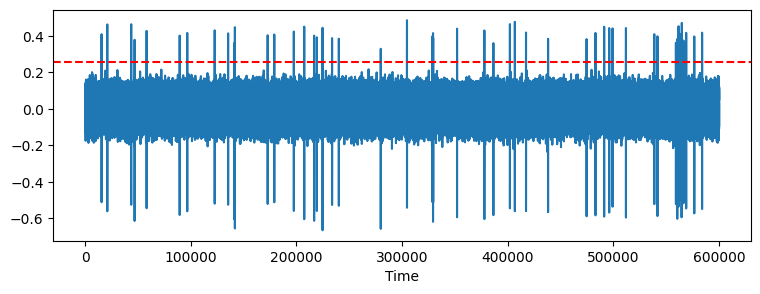

In [ ]:
trace=generate_spike_trace()
thresh=5*np.std(trace) # I decided to count as a spike anything that is over the 5 std deviations away from 0,
                      # as this seemed reasonable visually - clear oversemplification

fig, axes= plt.subplots(figsize=(9,3))
axes.plot(trace)
axes.axhline(thresh, color='red', linestyle='--')
axes.set_xlabel('Time')
fig.show()

### Exercise 0.1

Write a function to detect spikes!
The function should take the trace as input, and return the index of each spike as the output (as the index, you should take the position of the spike maximum)

Hint: a good strategy to detect such events is to set a threshold, and look for elements above it. This will not be enough! each spike could have more than 1 point above the threshold, but you want to make sure you take only the spike peak! For this, you will probably need a loop.

Hint: do not start from writing the function. First debug your code running it in a cell, then move it to a function.

Hint: if you want, you can quickly check out the results you are getting by making a scatter plot of the detected spikes overimposed on the electrophysiology trace! (use as x of the dots the indexes of the spikes, and as y the hight of the trace at those indexes)

Text(0.5, 0, 'Time')

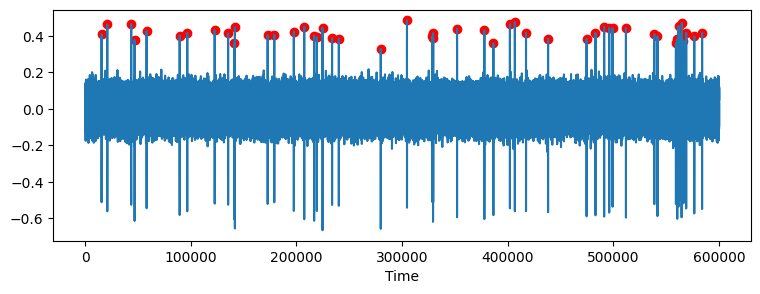

In [ ]:

def spike_detection(trace, thresh):
  ''' This function takes a trace as input and returns the indices spike (calculated as those timepoints where the signal surpasses the threshold)
  '''
  spike_ind=[index for index,value in enumerate(trace) if (value >thresh) and (value>trace[index-1] and value>trace[index+1])]
  return spike_ind

spike_index=spike_detection(trace, thresh)
len(spike_index)

# plotting the output fo the function as a sanity check.
# Here, I add a dot using scatter, with coordinates (spike index, value of trace at that index)

fig, axes= plt.subplots(figsize=(9,3))
axes.plot(trace)
axes.scatter(spike_index, trace[spike_index], color='red')
axes.set_xlabel('Time')



### Exercise 0.2

We now want to have a look at the shape of those spikes. For this, we will create a function that crops small chunks of the trace around each spike peak.

Write a `crop_event()` function that takes as inputs:
   - the recording array
   - the spike indexes
   - a `n_points_pad` variable specifying the number of points to include before and after the spike

And returns a matrix of shape `(n_spikes, n_points*2)` containing the trace chunks cropped around spike events!

Hint: A good strategy coult be initialize an empty matrix and then fill it in a loop with the trace around the spikes.

**This function can be very useful in many contexts!** You can use it every time you want to crop a timeseries around events (e.g., EEG data or video kinematics data around some stimuli). So keep it at hand in the future!

---

(_Optional_) Pro challenge: Try to do it without for loops! if you construct a matrix with the indexes of the points you want to exctract from the trace, you can use it directly to index the trace!
For indexing in this way, you want to build a matrix that looks like this:
```
array([[...t0-2, t0-1, t0, t0+1, t0+2...],
       [...t1-2, t1-1, t1, t1+1, t1+2...],
       [...t2-2, t2-1, t2, t2+1, t2+2...],])
```
Where `t0`, `t1`, `t2`... are the indexes of each spike, and you take as many points before and after as specified by the `n_points_pad` paramenter.

Building this matrix without loops is not trivial but it can be done nicely with numpy broadcasting!

Text(0.5, 0, 'Time')

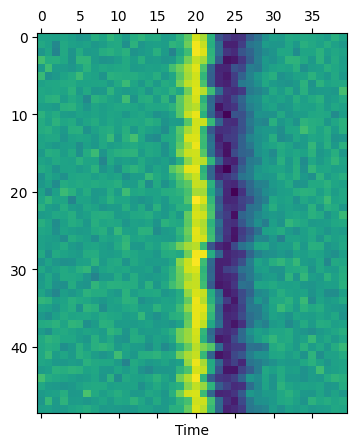

In [ ]:
def crop_event(recording_array, spike_index, n_points):
  ''' This function takes as input the array
  '''
  matrix = np.zeros((len(spike_index), n_points*2))
  for i in range(len(spike_index)):
    if i + n_points <= len(recording_array):
      matrix[i]=recording_array[(spike_index[i]-n_points):(spike_index[i]+n_points)]
    else:
      matrix[i]=0
  return matrix

matrix=crop_event(trace, spike_index,20)
plt.matshow(matrix)
plt.xlabel("Time")

#plt.colorbar()


### Exercise 0.3

Finally, make two subplots one close to the other. On the left, use `plt.matshow` to show the spike matrix. On the right,
plot each individual spike (rows of the matrix) using `plt.plot` with gray lines, and the average spike shape in red on top.

---

(Optional) If you want you can try to normalize the matrix before plotting by subtracting the average of each row (as we were doing for the daily temperatures)!

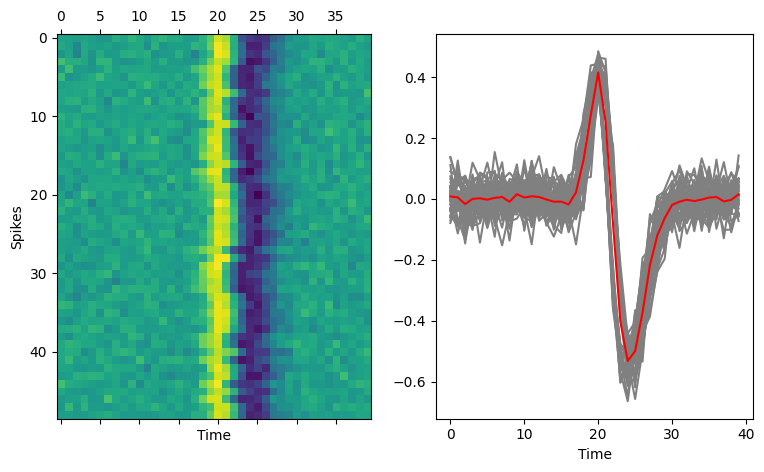

In [ ]:
#Step 1: calculate the avg spike shape
avg_spike_shape=matrix.mean(axis=0)

fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(9, 5))
ax1.matshow(matrix)
ax2.plot(matrix.T, color='grey')
ax2.plot(avg_spike_shape, color='red')
ax1.set_xlabel("Time")
ax1.set_ylabel("Spikes")
ax2.set_xlabel("Time")
fig.show()



## 1. Real books data

After having appreciated how many books the universe of all possible books contains, let's now focus just on the reachable ones - and how much people like them!

Here, we will download the information about about thousands volumns available on Amazon. Just a tiny fraction of Babel's books, but way more organized!

We will also get a dataset of users writing reviews, and a dataset of reviews.

### Exercise 1.0

Using, `pandas`, read the `.csv` files containing the books, the ratings, and the user data that you can find at the  urls defined below.

Then, plot an histogram of all the ratings from all users, and another histogram with the age of the users:

In [167]:
users_df_url = "https://github.com/vigji/python-cimec/raw/main/assignments/files/users.csv"
ratings_df_url = "https://github.com/vigji/python-cimec/raw/main/assignments/files/ratings.csv"
books_df_url = "https://github.com/vigji/python-cimec/raw/main/assignments/files/books.csv"


books=pd.read_csv(books_df_url)
users=pd.read_csv(users_df_url)
ratings=pd.read_csv(ratings_df_url)


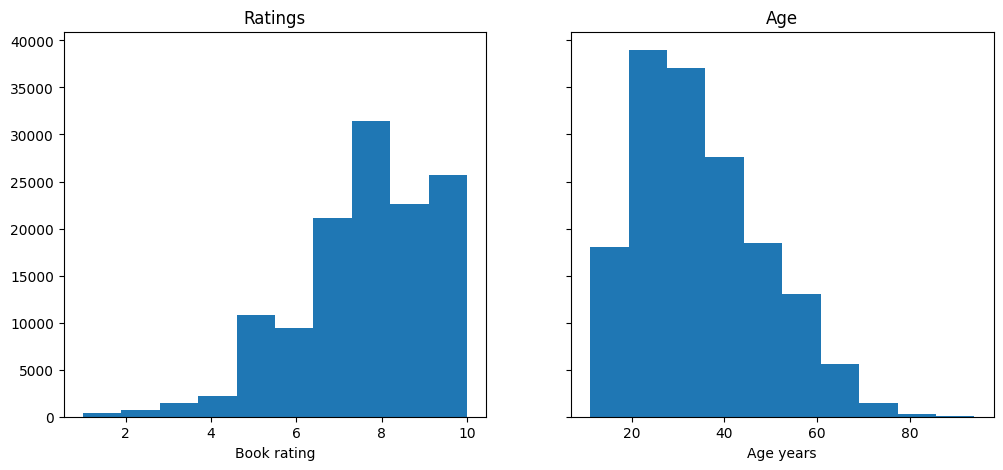

In [5]:
# plot an histogram of all the ratings from all users, and another histogram with the age of the users:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), sharey=True)
ax1.set_title('Ratings')
ax1.hist(ratings['rating'])
ax1.set_xlabel('Book rating')
ax2.set_title('Age')
ax2.set_xlabel('Age years')
ax2.hist(users['age'])
fig.show()


### Exercise 1.1

Using the ratings dataframe, compute the average rating for each book, and count how many reviews each book had. Then:
- find out which book had the highest number of reviews.
- find out which book had the highest average rating - but include only books that have at least 100 reviews!


Finally, look for the titles that correspond to those book codes (ISBNs are unique book codes).

 Average book rating: ISBN
0002251760    8.833333
0002255081    6.250000
0002550563    6.500000
0002558122    8.000000
0003300277    8.600000
                ...   
9722016563    6.500000
9722105248    8.500000
9726101794    6.000000
9728423160    7.000000
9871138148    8.800000
Name: rating, Length: 12401, dtype: float64


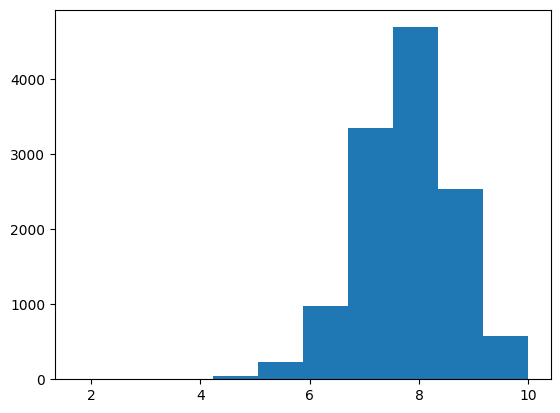

In [175]:
# Compute the average rating for each book
avg_rating=ratings.groupby("ISBN").mean()['rating']
print(f" Average book rating: {avg_rating}")


# Average book rating frequency
plt.hist(avg_rating)
plt.show()

In [176]:
# Top 5 most reviewed books:
most_reviewed_books = ratings['ISBN'].value_counts()[:10]
most_reviewed_books


0971880107    459
0316666343    448
0385504209    358
0312195516    219
0142001740    213
0671027360    210
059035342X    206
0786868716    199
0060928336    197
0446672211    186
Name: ISBN, dtype: int64

In [177]:
# Find the title of these 10 most reviewed books:
ISBN_most_reviewed_books=list(most_reviewed_books.to_frame().index)

title_most_reviewed_books = books[books['ISBN'].isin(ISBN_most_reviewed_books)]
title_most_reviewed_books

,ISBN,title,author
26,0971880107,Wild Animus,Rich Shapero
107,0786868716,The Five People You Meet in Heaven,Mitch Albom
118,0671027360,Angels &amp; Demons,Dan Brown
356,0142001740,The Secret Life of Bees,Sue Monk Kidd
408,0316666343,The Lovely Bones: A Novel,Alice Sebold
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts
748,0385504209,The Da Vinci Code,Dan Brown
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling


In [219]:
# find out which book had the highest average rating - but include only books that have at least 100 reviews!
# list of ISBN > 100 reviews
ISBN_filt = most_reviewed_books[ratings['ISBN'].value_counts()>100]
ISBN_filt=ISBN_filt.index.values.tolist()

ISBN_book_with_highest_avg_rating=ratings[ratings['ISBN'].isin(ISBN_filt)].groupby("ISBN").mean()['rating'].idxmax()
ISBN_book_with_highest_avg_rating


# Title of book with the higher average rating
books[books['ISBN']==ISBN_book_with_highest_avg_rating]

,ISBN,title,author
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling


### Exercise 1.2

Let's get even more specific! Let's find the preferences of users in specific countries and with different ages.

Use the users DataFrame to select only italian users under 40 years old. Then, go back to the reviews dataframe and filter only reviews from those users. Compute the average ratings (include only books that have at least 3 reviews) and sort the ISBNs by average rating. Finally, find the books corresponding to each ISBN code to get which books got the best ratings in this coort of people!

(_Optional_): from the users DataFrame generate a list of all the countries present in the dataset. Then, find the highest rated book in each one of those countries.

In [204]:
# Get the user dataframe and select only italian users < 40

subset_users=pd.DataFrame()
subset_users=users[(users.age < 40) & (users.country == 'italy')]
subset_users

,user_id,age,country
20,38,34.0,italy
26,47,21.0,italy
80,157,36.0,italy
136,253,28.0,italy
147,274,26.0,italy
...,...,...,...
160502,278513,37.0,italy
160545,278606,38.0,italy
160560,278638,27.0,italy
160586,278688,37.0,italy


In [218]:
# filter only reviews from those users
reviews_from_these_users=ratings[ratings['user_id'].isin(subset_users['user_id'])]
reviews_from_these_users

,user_id,ISBN,rating
1677,2738,0743222229,8
1764,2996,0345361792,8
1765,2996,0425118703,7
2076,3816,0451099648,7
2351,4334,0060392452,6
...,...,...,...
124996,274546,0385508417,10
125513,276039,0451164075,5
125514,276039,8845915611,7
125566,276147,0060977493,9


In [236]:
 # Compute the average ratings (include only books that have at least 3 reviews)...

ISBN_filt=(reviews_from_these_users['ISBN'].value_counts()>3).index
avg_rating=ratings[ratings['ISBN'].isin(ISBN_filt)].groupby("ISBN").mean()['rating']
avg_rating


ISBN
002542730X    8.111111
0060392452    8.039216
0060926317    7.620690
0060927216    7.750000
0060976845    7.669355
                ...   
8845247414    9.600000
8845407039    7.250000
884590184X    7.500000
8845915611    8.800000
8885989403    5.000000
Name: rating, Length: 172, dtype: float64

In [237]:
# ... and sort the ISBNs by average rating.
avg_rating_sorted=avg_rating.sort_index()
avg_rating_sorted

ISBN
002542730X    8.111111
0060392452    8.039216
0060926317    7.620690
0060927216    7.750000
0060976845    7.669355
                ...   
8845247414    9.600000
8845407039    7.250000
884590184X    7.500000
8845915611    8.800000
8885989403    5.000000
Name: rating, Length: 172, dtype: float64

In [245]:
# Finally, find the books corresponding to each ISBN code to get which books got the best ratings in this coort of people!
# Top 10 books in Italy for people under 40:
top_10_ratings=avg_rating.sort_values(ascending=False).index[:10]
top_10_ratings

top_10_books = books[books['ISBN'].isin(top_10_ratings)]
top_10_books

Index(['0345418913', '8845247414', '017443460X', '0141301066', '0312966555',
       '0156012197', '0812505166', '0439136350', '089471273X', '8845205118'],
      dtype='object', name='ISBN')